# What is the optimal action for short-term FX transactions between SG and MYR?

Imagine the following: 

1. You have to move a non-trivial sum of $$ from SGD to MYR. 
2. This has to happen within the next 12 months. 

This is balanced against the following:
- The funds are currently in a unit trust doing its job. But at the moment, the markets aren't that great....
- If transferred, the funds will then be in a `fixed deposit` or `money market` fund. 

As the responsible adult, you need to make a decision. You want to maximize the net gain such that:

$$
\begin{align}
y = t*r_1 + (d-t)*r_2 + e
\end{align}
$$ 

where
- y: net gain (in %)
- t: time period of time in SGD (in days)
- d: total period of time till funds in needed (in days)
- r1: rate of return in SGD (in days)
- r2: rate of return in MYR (in days)
- e: exchange rate change from present rate (assumeed to be SGD->MYR 3.35)


You are starting to sweat. This decision feels like a game of luck because WHO KNOWS WHAT THE FUTURE HOLDS?! 



## `e`: How volatile are the FX Rates?

The first step is understanding the problem: how volatile are the FX rates? What exactly is at stake? 



In [29]:
# Get the FX rates of SGD->MYR for the past 6 months
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import requests
from pprint import pprint

API_URL = "https://www.alphavantage.co/query"
API_KEY = "0SBRTSPM95BI6E5J"

start_date = "2024-03-01"
end_date = "2024-09-01"
parameters = {
    "function": "FX_DAILY",
    "from_symbol": "SGD",
    "to_symbol": "MYR",
    "datatype": "json",
    "apikey": API_KEY,
}

response = requests.get(API_URL,parameters).json()

pprint(
    response["Meta Data"]
)

{'1. Information': 'Forex Daily Prices (open, high, low, close)',
 '2. From Symbol': 'SGD',
 '3. To Symbol': 'MYR',
 '4. Output Size': 'Compact',
 '5. Last Refreshed': '2024-09-13',
 '6. Time Zone': 'UTC'}


In [81]:
import numpy as np
import matplotlib.pyplot as plt

def to_pandas(data):
    time_series = data['Time Series FX (Daily)']
    df = pd.DataFrame.from_dict(time_series).transpose()
    df = df.rename(columns={
        '1. open': 'open', 
        '2. high': 'high', 
        '3. low': 'low', 
        '4. close': 'close'
        })
    
    # Type casting
    for col in df:
        df[col] = df[col].astype(float)
    df.index = pd.to_datetime(df.index)
    
    df.sort_index(ascending=False, inplace=True)

    # Calculate volatility
    df["log_return"] = np.log(df['close'] / df['close'].shift(1))
    df["volatility"] = df["log_return"].rolling(window=3).std()

    print("Processed DF: ")
    print(df.head())
    print(df.tail())


    return df

df = to_pandas(response)

# sns.lineplot(x="date", y="value", data=df)

Processed DF: 
              open    high     low   close  log_return  volatility
2024-09-13  3.3287  3.3300  3.3277  3.3277         NaN         NaN
2024-09-12  3.3224  3.3329  3.3182  3.3329    0.001561         NaN
2024-09-11  3.3268  3.3303  3.3184  3.3210   -0.003577         NaN
2024-09-10  3.3471  3.3482  3.3228  3.3279    0.002076    0.003126
2024-09-09  3.3225  3.3509  3.3225  3.3473    0.005813    0.004727
              open    high     low   close  log_return  volatility
2024-05-03  3.5096  3.5197  3.4951  3.5115    0.001368    0.001374
2024-05-02  3.5062  3.5110  3.4959  3.5097   -0.000513    0.001554
2024-05-01  3.4953  3.5084  3.4953  3.5078   -0.000542    0.001094
2024-04-30  3.5051  3.5078  3.4978  3.4987   -0.002598    0.001195
2024-04-29  3.5031  3.5123  3.5014  3.5065    0.002227    0.002421


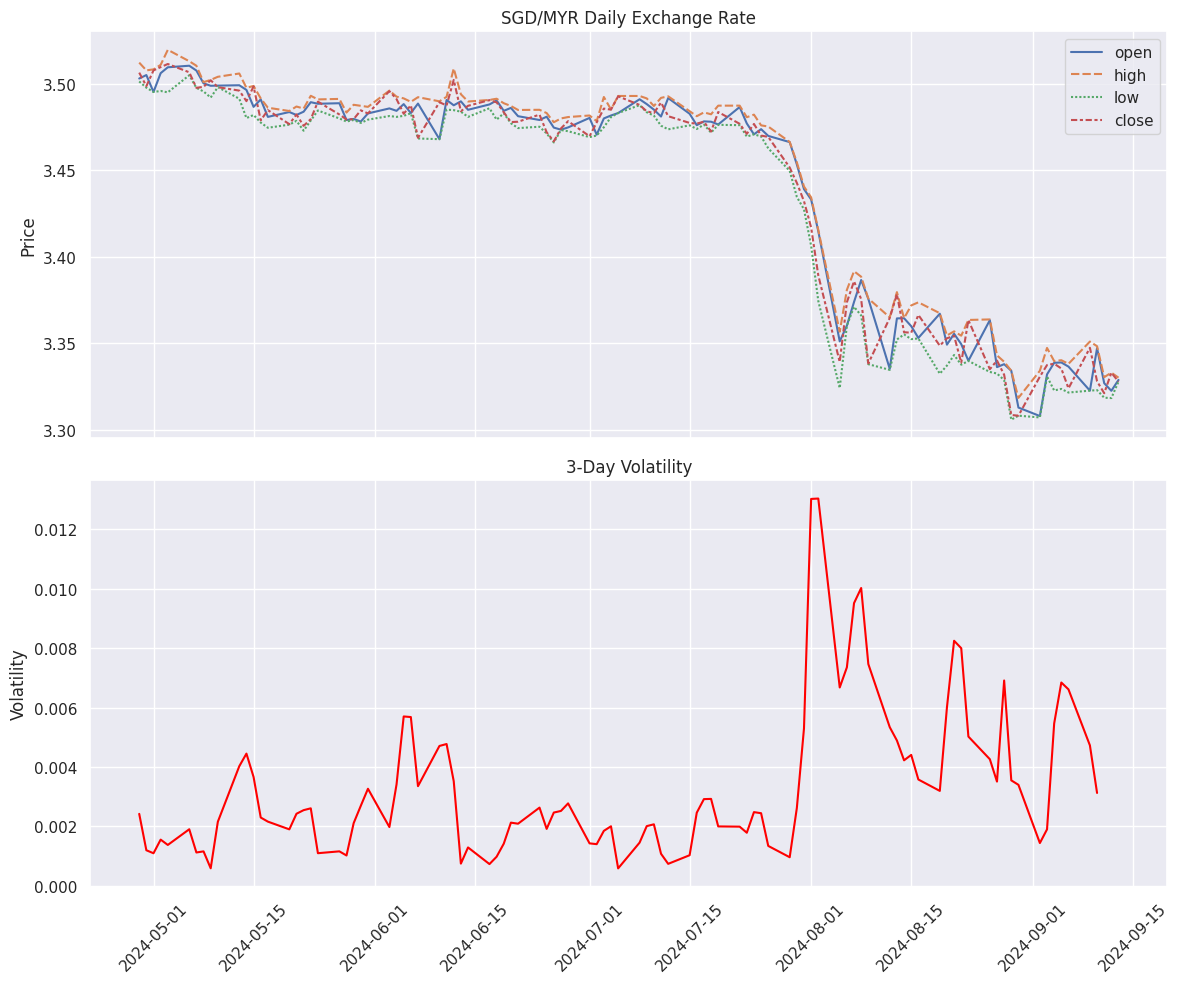

In [83]:
import matplotlib.pyplot as plt
def plot_forex_data(df):
    sns.set_style("darkgrid")
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Plot all price data
    sns.lineplot(data=df[['open', 'high', 'low', 'close']], ax=ax1)
    ax1.set_title('SGD/MYR Daily Exchange Rate')
    ax1.set_ylabel('Price')
    
    # Plot volatility
    sns.lineplot(data=df['volatility'], ax=ax2, color='red')
    ax2.set_title('3-Day Volatility')
    ax2.set_ylabel('Volatility')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_forex_data(df)


# resample_df_to_weekly()
        index    open    high     low   close
0 2024-05-05  3.5031  3.5197  3.4951  3.5115
1 2024-05-12  3.5105  3.5131  3.4921  3.4981
2 2024-05-19  3.4992  3.5060  3.4746  3.4848
3 2024-05-26  3.4837  3.4931  3.4729  3.4897
4 2024-06-02  3.4888  3.4913  3.4774  3.4829

# melt_df_to_long()
         index variable   value
50 2024-07-14      low  3.4737
37 2024-09-01     high  3.3637
39 2024-09-15     high  3.3509
13 2024-08-04     open  3.4663
53 2024-08-04      low  3.3744
7  2024-06-23     open  3.4881
4  2024-06-02     open  3.4888
54 2024-08-11      low  3.3240
12 2024-07-28     open  3.4866
58 2024-09-08      low  3.3070


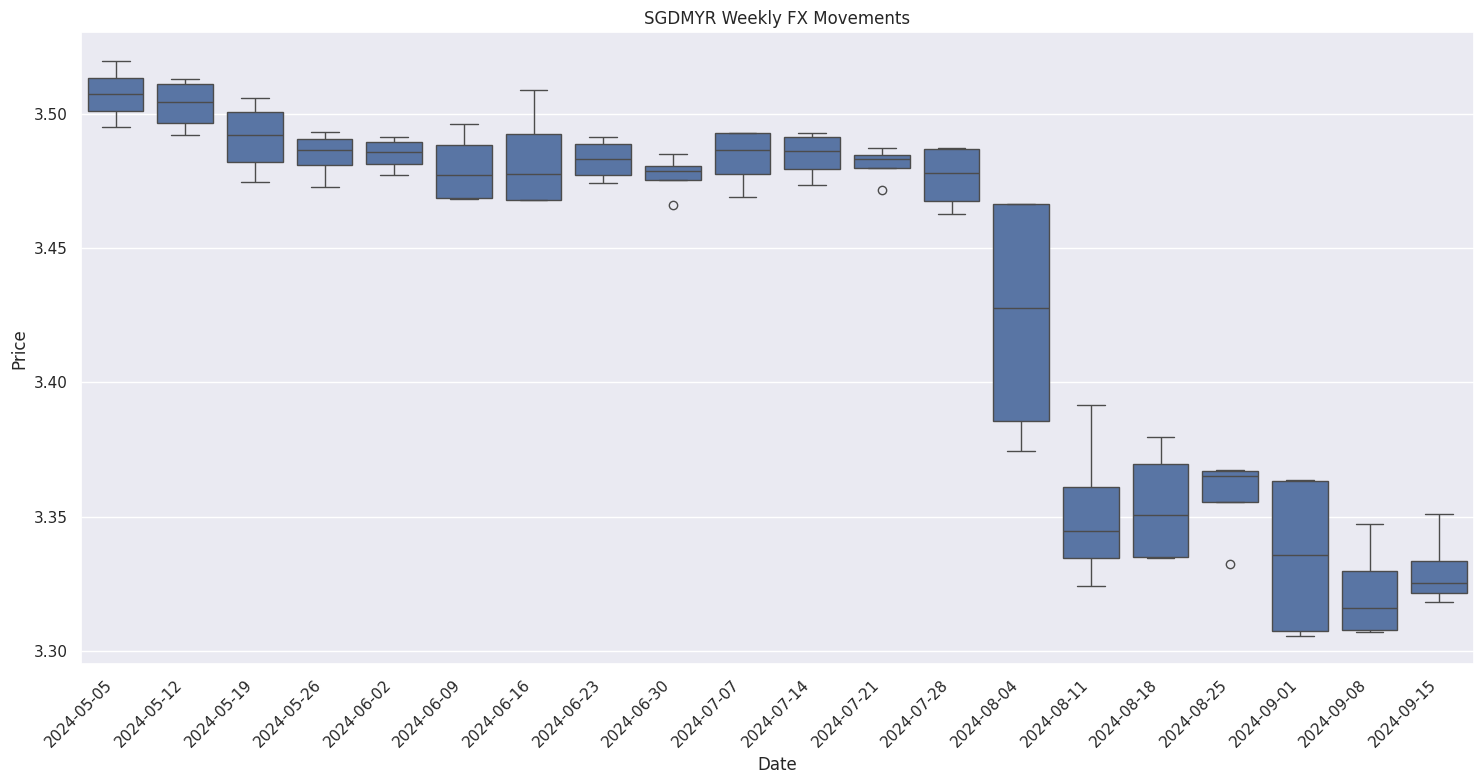

In [97]:
import inspect
import logging

def get_current_function_name():
    return "\n# " + inspect.currentframe().f_back.f_code.co_name + "()\n"

# Resample to weekly frequency
def resample_df_to_weekly(df):
    """
    This code is performing weekly resampling of the DataFrame 'df' and aggregating the data. 

    - df.resample('W'): This method resamples the DataFrame to a weekly frequency. The 'W' argument specifies weekly resampling.
    - .agg({...}): This applies different aggregation functions to specific columns.

    The dictionary inside agg() specifies how each column should be aggregated:
    - 'open': 'first' - Takes the first value of 'open' for each week
    - 'high': 'max' - Takes the maximum value of 'high' for each week
    - 'low': 'min' - Takes the minimum value of 'low' for each week
    - 'close': 'last' - Takes the last value of 'close' for each week
    """
    df = df.resample('W').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last'
    })
    df.reset_index(inplace=True)
    print(get_current_function_name(), df.head() )

    return df


# Melt the dataframe to long format
def melt_df_to_long(df):
    """
    This function takes a DataFrame as input and melts it into a long format.
    
    Key cols returned are: 
    - index: timeseries
    - variable: the melted column name
    - value: the value of the melted column
    """
    df = pd.melt(
    weekly_df,
    id_vars=['index'],
    value_vars=['open', 'high', 'low', 'close']
    )
    print(get_current_function_name(), df.sample(10) )
    return df

weekly_df = resample_df_to_weekly(df)
weekly_long = melt_df_to_long(weekly_df)

# Create the box plot
plt.figure(figsize=(15, 8))
sns.boxplot(data = weekly_long, x = 'index', y = 'value')

plt.title('SGDMYR Weekly FX Movements')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## `r`: what can be expected from the investment products?